In [1]:
import numpy as np

import pandas as pd

import seaborn as sns

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import BernoulliRBM
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV


In [3]:
%pylab inline
matplotlib.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [4]:
train_df = pd.read_csv('train.csv')

In [5]:
train_df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [6]:
train_df.OutcomeType.value_counts()

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: OutcomeType, dtype: int64

In [7]:
train_df.SexuponOutcome.value_counts()

Neutered Male    9779
Spayed Female    8820
Intact Male      3525
Intact Female    3511
Unknown          1093
Name: SexuponOutcome, dtype: int64

In [8]:
train_df.Breed.value_counts()

Domestic Shorthair Mix                     8810
Pit Bull Mix                               1906
Chihuahua Shorthair Mix                    1766
Labrador Retriever Mix                     1363
Domestic Medium Hair Mix                    839
German Shepherd Mix                         575
Domestic Longhair Mix                       520
Siamese Mix                                 389
Australian Cattle Dog Mix                   367
Dachshund Mix                               318
Boxer Mix                                   245
Miniature Poodle Mix                        233
Border Collie Mix                           229
Australian Shepherd Mix                     163
Rat Terrier Mix                             157
Catahoula Mix                               157
Jack Russell Terrier Mix                    146
Yorkshire Terrier Mix                       143
Domestic Shorthair                          143
Chihuahua Longhair Mix                      142
Siberian Husky Mix                      

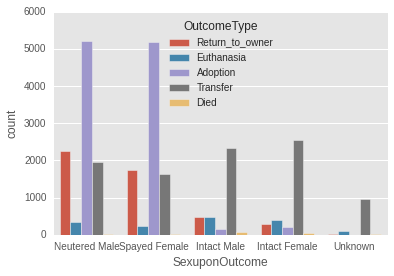

In [11]:
#train_df[train_df['Breed'].str.contains("Mix")]
sns.countplot(x=train_df['SexuponOutcome'],hue=train_df['OutcomeType'])

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 10 columns):
AnimalID          26729 non-null object
Name              19038 non-null object
DateTime          26729 non-null object
OutcomeType       26729 non-null object
OutcomeSubtype    13117 non-null object
AnimalType        26729 non-null object
SexuponOutcome    26728 non-null object
AgeuponOutcome    26711 non-null object
Breed             26729 non-null object
Color             26729 non-null object
dtypes: object(10)
memory usage: 2.0+ MB


In [13]:
train_df.Color.value_counts()

Black/White                  2824
Black                        2292
Brown Tabby                  1635
Brown Tabby/White             940
White                         931
Brown/White                   884
Orange Tabby                  841
Tan/White                     773
Tricolor                      752
Blue/White                    702
Black/Tan                     672
White/Black                   643
Brown                         639
Tan                           628
White/Brown                   569
Tortie                        530
Calico                        517
Orange Tabby/White            455
Brown Brindle/White           450
Blue                          450
Black/Brown                   436
Blue Tabby                    433
White/Tan                     389
Red                           337
Torbie                        335
Brown/Black                   333
Red/White                     331
Blue Tabby/White              241
Brown Brindle                 232
Chocolate/Whit

In [14]:
test = pd.to_datetime(train_df.DateTime[0])
test.hour

18

In [5]:
def ageCalc(s):
    if s is None: return -1
    
    ageStr = str(s).split(' ')
    age = -1
    try:
        if 'year' in ageStr[1]:
            age = int(ageStr[0]) * 365
        elif 'day' in ageStr[1]:
            age = int(ageStr[0])
        elif 'month' in ageStr[1]:
            age = int(ageStr[0]) * 30
        elif 'week' in ageStr[1]:
            age = int(ageStr[0]) * 7
    except:
        pass
    
    return age

def ageSimple(s):
    if s is None: return -1
    
    try:
        ageStr = str(s).split(' ')
        age = -1
        if 'year' in ageStr[1]:
            age = 3
        elif 'day' in ageStr[1]:
            age = 0
        elif 'month' in ageStr[1]:
            age = 2
        elif 'week' in ageStr[1]:
            age = 1
    except:
        pass
            
    return age

def timeOfDay(s):
    if s is None: return -1
    
    time = pd.to_datetime(s)
    ToD = -1
    if time.hour < 5:
        ToD = 0
    elif time.hour < 11:
        ToD = 1
    elif time.hour < 16:
        ToD = 2
    elif time.hour < 20:
        ToD = 3
    
    return ToD

In [6]:
def prepareData(df, train_flag):
    returnDF = pd.DataFrame()
    if train_flag:
        returnDF['OType'] = df.OutcomeType.map( {'Return_to_owner': 0, 'Euthanasia': 1, 'Transfer': 2, 'Adoption': 3, 'Died': 4})
        returnDF['OutcomeType'] = df.OutcomeType
    returnDF['AType'] = df.AnimalType.map( {'Dog': 0, 'Cat': 1})
    returnDF['Sex'] = df.SexuponOutcome.map( {'Neutered Male': 0, 'Spayed Female': 1, 'Intact Male': 2, 'Intact Female': 3, 'Unknown': -1})
    returnDF['Intact'] = df.SexuponOutcome.map( {'Neutered Male': 0, 'Spayed Female': 0, 'Intact Male': 1, 'Intact Female': 1, 'Unknown': -1})
    returnDF['NoName'] = df.Name.isnull().astype(int)
    returnDF['DoW'] = pd.to_datetime(df.DateTime).dt.day
    returnDF['Month'] = pd.to_datetime(df.DateTime).dt.month
    returnDF['AgeDays'] = df.AgeuponOutcome.map(ageCalc)
    returnDF['AgeSimple'] = df.AgeuponOutcome.map(ageSimple)
    returnDF['Time'] = df.DateTime.map(timeOfDay)
    returnDF['Breed'] = df.Breed.map({
            'Domestic Shorthair Mix': 0,
            'Pit Bull Mix': 1,
    'Chihuahua Shorthair Mix': 2,
    'Labrador Retriever Mix': 3,
    'Domestic Medium Hair Mix': 4,
    'German Shepherd Mix': 5,
    'Domestic Longhair Mix': 6,
    'Siamese Mix': 7,
    'Australian Cattle Dog Mix': 8,
    'Dachshund Mix': 9,
    'Boxer Mix': 10,
    'Miniature Poodle Mix': 11,
    'Border Collie Mix': 12
        })
    
    returnDF.Breed = returnDF.Breed.fillna(-1)
    
    returnDF.dropna(inplace=True)
    
    return returnDF

In [7]:
prepTraindf = prepareData(train_df, 1)
len(prepTraindf)

26728

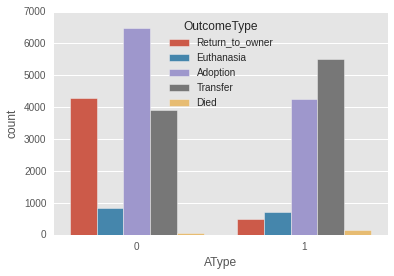

In [24]:
sns.countplot(x="AType",hue="OutcomeType",data=prepTraindf)

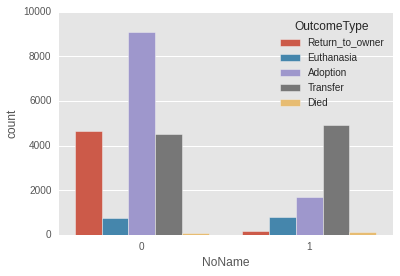

In [23]:
sns.countplot(x="NoName",hue="OutcomeType",data=prepTraindf)

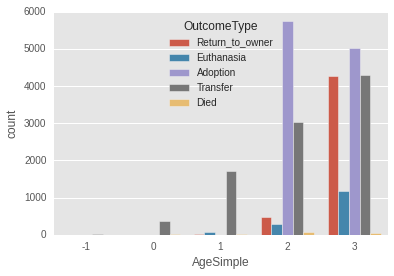

In [22]:
sns.countplot(x="AgeSimple",hue="OutcomeType",data=prepTraindf)

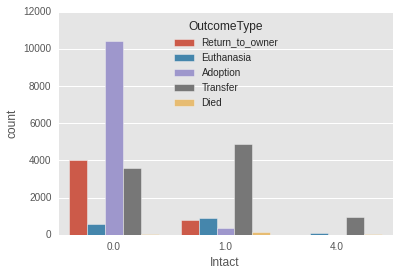

In [28]:
sns.countplot(x="Intact",hue="OutcomeType",data=prepTraindf)

In [86]:
def shelterScore(prediction,actual):
    n = len(prediction)
    m = 5
    logloss = 0
    for i in range(n):
        for j in range(m):
            if prediction[i,j] != 0:
                logloss += -(1.0/n)*actual[i,j]*np.log(prediction[i,j])
    return logloss

In [9]:
# one-hot encoding for outcomes
outcomeTypes = pd.get_dummies(prepTraindf.OutcomeType)

In [232]:
features = ["AType","AgeSimple","Intact","Time","NoName","DoW","Month"]
x_train, x_test, y_train, y_test = cross_validation.train_test_split(prepTraindf[features],outcomeTypes, test_size=0.3)

# Logisitic Regression

In [233]:
x_train_lr, x_test_lr, y_train_lr, y_test_lr = cross_validation.train_test_split(prepTraindf[features],prepTraindf.OType, test_size=0.3)

In [234]:
LR = LogisticRegression(penalty='l2',C=1.0,multi_class='ovr')
LR.fit(x_train_lr,y_train_lr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [235]:
outScore = LR.predict_proba(x_test_lr)
    
print shelterScore(outScore,np.array(pd.get_dummies(y_test_lr)))

0.975132757567


In [236]:
LRCV = LogisticRegressionCV(cv=3,Cs=10,scoring='log_loss')
LRCV.fit(x_train_lr,y_train_lr)

outScore = LRCV.predict_proba(x_test_lr)
    
print shelterScore(outScore,np.array(pd.get_dummies(y_test_lr)))

0.974994990537


# Random Forest Classifier

In [237]:
#def run_fit(ne, md):
forest = RandomForestClassifier(n_estimators=3, max_depth=4)
forest.fit(x_train,y_train)
outScore = forest.predict_proba(x_test)

scoreL = np.zeros((len(outScore[0]),len(outScore)))
i = 0
for cl in outScore:
    j = 0
    for animal in cl:
        scoreL[j][i] = animal[1]
        j += 1
    i += 1

print shelterScore(scoreL,np.array(y_test))

#run_fit(15,3)

0.933763445122


In [238]:
forestCV = RandomForestClassifier()
parameters = {'n_estimators': [2,6,10,14,16,20,24], 'max_depth': [2,6,8,12,14]}
clf = GridSearchCV(forestCV, parameters,scoring='log_loss',cv=3)

In [239]:
clf.fit(x_train_lr,y_train_lr)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [2, 6, 10, 14, 16, 20, 24], 'max_depth': [2, 6, 8, 12, 14]},
       pre_dispatch='2*n_jobs', refit=True, scoring='log_loss', verbose=0)

In [240]:
outScore = clf.predict_proba(x_test_lr)
print shelterScore(outScore,np.array(pd.get_dummies(y_test_lr)))
clf.best_params_

0.838629140555


{'max_depth': 8, 'n_estimators': 16}

In [96]:
_min = 100
bestNE = 0
bestMD = 0
for i in range(10):
    for j in range(10):
        val = run_fit(i+1,j+1)
        if val < _min:
            _min = val
            bestNE = i+1
            bestMD = j+1
            
print bestNE,bestMD

1 10


In [200]:
test_df = pd.read_csv('test.csv')

In [201]:
prepTestdf = prepareData(test_df, 0)
len(prepTestdf)

11456

In [202]:
output = clf.predict_proba(prepTestdf[features])
outputLR = LR.predict_proba(prepTestdf[features])

In [241]:
print output[4]
print outputLR[4]

[ 0.39341753  0.02781031  0.09286513  0.4839038   0.00200323]
[ 0.36563559  0.03619191  0.08682167  0.51017302  0.00117781]


In [51]:
l = np.zeros((len(output[0]),len(output)))
i = 0
for cl in output:
    j = 0
    for animal in cl:
        l[j][i] = animal[1]
        j += 1
    i += 1

In [213]:
#out_df = pd.DataFrame(l)
out_df = pd.DataFrame(output)

outDF = pd.DataFrame( {'AAnimalID': test_df['ID'], 'Adoption': out_df[3], 'Died': out_df[4], 'Euthanasia': out_df[1],'Return_to_owner': out_df[0], 'Transfer': out_df[2]} )
outDF.to_csv('randomForestCV_v1.csv',index=False)

# SVC

In [242]:
svc = SVC(probability=True)
svc.fit(x_train_lr,y_train_lr)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [243]:
scoreSVC = svc.predict_proba(x_test_lr)
    
print shelterScore(scoreSVC,np.array(pd.get_dummies(y_test_lr)))

0.912696790205


# XGBoost

In [4]:
import xgboost as xgb

In [ ]:
dtrain = xgb.DMatrix('train.csv')

# Ensemble

In [217]:
outputEnsemble = (output + outputLR)/2

In [220]:
out_df = pd.DataFrame(outputEnsemble)

outDF = pd.DataFrame( {'AAnimalID': test_df['ID'], 'Adoption': out_df[3], 'Died': out_df[4], 'Euthanasia': out_df[1],'Return_to_owner': out_df[0], 'Transfer': out_df[2]} )
outDF.to_csv('ensemble_v1.csv',index=False)